# Notebook 3
Export of slices as tiff images from a custom selection of lipids for optimal registration

### Load important modules

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from xtiff import to_tiff
import tables
import copy
import pickle

# multithreading
from threadpoolctl import threadpool_limits

# Move to root directory for easier module import
os.chdir("../../")

# Import custom function
from lbae.modules.tools.lookup_functions import return_image_per_lipid


# set thread limit
threadpool_limits(16)

### Load the slice data and the corresponding annotations

In [2]:
df_annotation = pd.read_csv("lbae/data/annotations/lipid_annotation.csv")
l_slices = []
n_slices = 0

path_hdf5 = "lbae/data/whole_dataset/slices.hdf5"
with tables.open_file(path_hdf5, mode='r') as hdf5_file:
    l_slices = copy.copy(hdf5_file.root.__members__)
    n_slices = len(l_slices)

path_pickle = "lbae/data/whole_dataset/slices.pickle"
with open(path_pickle, 'rb') as handle:
    dic_slices = pickle.load(handle)
        
print(n_slices, 'slices are present in the dataset')
print(l_slices)


32 slices are present in the dataset
['s9', 's8', 's7', 's6', 's5', 's4', 's32', 's31', 's30', 's3', 's29', 's28', 's27', 's26', 's25', 's24', 's23', 's22', 's21', 's20', 's2', 's19', 's18', 's17', 's16', 's15', 's14', 's13', 's12', 's11', 's10', 's1']


### Keep only most prevalent lipids

In [3]:
# Merge columns 'name' 'structure' and 'cations'
df_annotation["full_name_lipid"] = df_annotation["name"] + df_annotation["structure"] + df_annotation["cation"]
df_annotation = df_annotation.drop(["name", "structure", "cation"], axis=1)
df_annotation


,slice,theoretical m/z,min,max,num_pixels,mz_estimated,full_name_lipid
0,1,420.154791,420.1517,420.1554,2087.0,420.1535,GP01_PCPCOTheo_8:1k
1,1,450.297880,450.2964,450.3000,725.0,450.2980,GP01_PCPCdOTheo_14:2H
2,1,454.292820,454.2918,454.2955,846.0,454.2934,GP01_PCPCOTheo_13:0H
3,1,464.313540,464.3087,464.3116,542.0,464.3106,GP01_LysoPCLPCOTheo_15:2H
4,1,464.313540,464.3121,464.3161,1016.0,464.3139,GP01_LysoPCLPCOTheo_15:2H
...,...,...,...,...,...,...,...
22867,32,1148.054250,1148.0529,1148.0574,1748.0,1148.0555,GL03_TAGTGTheo_71:2na
22868,32,1152.028082,1152.0273,1152.0321,2000.0,1152.0307,GL03_TAGTGTheo_70:1k
22869,32,1158.884770,1158.8813,1158.8864,6438.0,1158.8839,GL03_TAGTGOTheo_76:22NH4
22870,32,1162.070000,1162.0684,1162.0764,25861.0,1162.0720,GL03_TAGTGTheo_72:2na


In [4]:
# Keep only lipids present in all slices and remove all others
l_most_prevalent_lipids = list(df_annotation["full_name_lipid"].value_counts()[:120].index)
df_annotation = df_annotation[df_annotation["full_name_lipid"].isin(l_most_prevalent_lipids)]
df_annotation


,slice,theoretical m/z,min,max,num_pixels,mz_estimated,full_name_lipid
42,1,524.274795,524.2730,524.2775,29182.0,524.2755,GP01_PCPCOTheo_17:4na
74,1,564.535030,564.5329,564.5366,5145.0,564.5349,SP02_CEREX2010003_36:2H
81,1,574.553385,574.5537,574.5574,4918.0,574.5556,SP00_OthSLSP0018_36:0na
84,1,580.529910,580.5270,580.5314,5728.0,580.5292,SP02_CER2010071_36:2H
85,1,582.295661,582.2936,582.2974,30481.0,582.2955,GP01_LysoPC1050048_20:4k
...,...,...,...,...,...,...,...
22736,32,907.772640,907.7708,907.7746,639.0,907.7725,GL03_TAGEX3010233_54:3na
22739,32,909.546440,909.5434,909.5483,23727.0,909.5458,GP06_PI6010010_38:4na
22750,32,923.504652,923.5015,923.5068,22483.0,923.5040,GP06_PI6010193_38:5k
22798,32,1036.001890,1035.9975,1036.0015,4482.0,1036.0013,GL03_TAGTGdOTheo_65:2na


### Get the corresponding images

In [6]:
dic_l_images = {}
with tables.open_file(path_hdf5, mode='r') as hdf5_file:
    for slice_name in l_slices:
        slice_hdf5 = hdf5_file.root[slice_name]
        slice_dic = dic_slices[slice_name]
        index_slice = int(slice_name.split("s")[1])
        df_currentSlice = df_annotation[df_annotation["slice"] == index_slice]
        l_images = []
        for lipid in l_most_prevalent_lipids:
            row_lipid = df_currentSlice[df_currentSlice["full_name_lipid"] == lipid]
            # Sum over lipids that have similar annotation
            im_lipid = np.nansum(
                [return_image_per_lipid(row[1]["min"], row[1]["max"], slice_hdf5['array_spectra'][:], slice_dic['array_lookup_pixels'], slice_dic['image_shape'], slice_hdf5['array_lookup_mz'][:], slice_hdf5['array_cumulated_lookup_mz_image'][:], slice_dic['divider_lookup']) for row in row_lipid.iterrows()], axis=0
            )
            l_images.append([im_lipid, lipid])
        dic_l_images[index_slice] = l_images


/home/colas/miniconda3/lib/python3.9/site-packages/tables/leaf.py:402: PerformanceWarning: The Leaf ``/s9/array_spectra`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUse of unsupported NumPy function 'numpy.clip' or unsupported use of the function.
[1m
File "lbae/modules/tools/lookup_functions.py", line 251:[0m
[1mdef return_image_per_lipid(
    <source elided>
    image = image / np.percentile(image, percentile_normalization) * 1
[1m    image = np.clip(0, 1, image)
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at /home/colas/lbae/lbae/modules/tools/lookup_functions.py (251)[0m
[1m
File "lbae/modules/tools/lookup_functions.py", line 251:[0m
[1mdef return_image_per_lipid(
    <source elided>
    image = image / np.percentile(image, percentile_normalization) * 1
[1m    image = np.clip(0, 1, image)
[0m    [1m^[0m[0m


### Display results and choose the lipids that represent the brain best

In [25]:
# Register total ion content + main lipids in a jpg file
l_index_slices = list(range(10, 33))

fig, ll_ax = plt.subplots(
    len(l_most_prevalent_lipids[:100]), len(l_index_slices), figsize=(160, len(l_most_prevalent_lipids[:100]) * 4)
)

for i, index in enumerate(l_index_slices):

    ll_ax[0, i].imshow(
        np.sum([image[0] for index_lipid, image in enumerate(dic_l_images[index]) if len(image[0].shape) > 0], axis=0)
    )
    ll_ax[0, i].axis("off")
    ll_ax[0, i].set_title("slice: " + str(index) + ", TIC ")

    for j, image in enumerate(dic_l_images[index][:99]):
        try:
            ll_ax[j + 1, i].imshow(image[0])
            ll_ax[j + 1, i].axis("off")
            ll_ax[j + 1, i].set_title("slice: " + str(index) + ", lipid: " + image[1] + " (" + str(j) + ")")
        except:
            pass

plt.tight_layout()
plt.savefig("notebooks/server/data/images/all_slices.jpg", dpi=72)
# fig.subplots_adjust(hspace=0.1)
plt.close()


In [31]:
# Define the lipids index we want to keep for registration
ll_index_to_keep = [
    [3, 3, 3, 12, 21, 22, 23, 39, 40, 40, 40, 43, 61, 71, 75, 78, 80, 83, 83, 83, 83, 98, 98, 98],  # Red, full brain
    [0, 4, 5, 8, 13, 27, 28, 30, 32, 34, 42, 57, 60, 82, 85, 87, 88, 95, 97],  # Green, specific structures
    list(dic_l_images.keys()),  # Blue, TIC
]



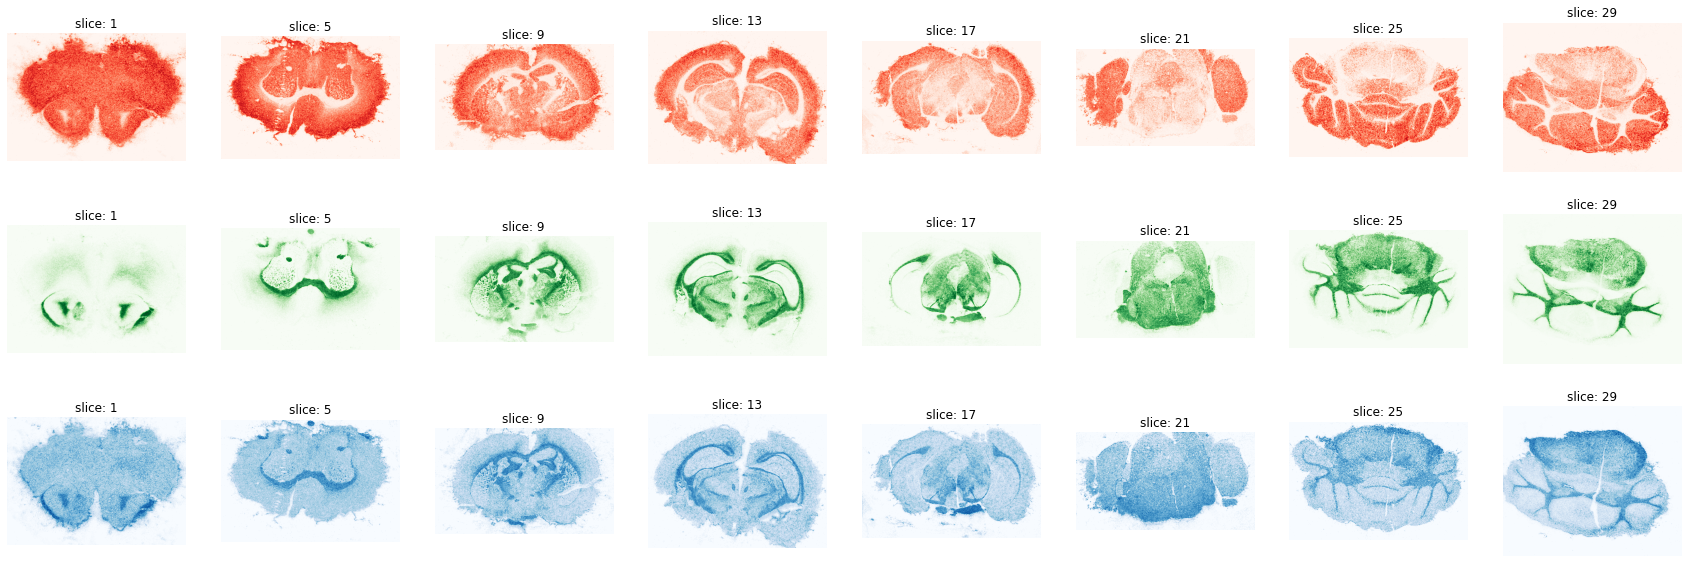

In [36]:
l_index_slices = list(range(1, 33, 4))
l_cmap = ["Reds", "Greens", "Blues"]
fig, ll_ax = plt.subplots(3, len(l_index_slices), figsize=(30, 10))

for i, index in enumerate(l_index_slices):
    for j, l_index_to_keep in enumerate(ll_index_to_keep):
        image = np.sum(
            [
                image[0]
                for index_lipid, image in enumerate(dic_l_images[index])
                if index_lipid in l_index_to_keep and len(image[0].shape) > 0
            ],
            axis=0,
        )
        image_norm = image / np.max(image) * 255
        ll_ax[j, i].imshow(image_norm, cmap=l_cmap[j])
        ll_ax[j, i].axis("off")
        ll_ax[j, i].set_title("slice: " + str(index))

plt.savefig("notebooks/server/data/images/lipidschannels.png")
plt.show()


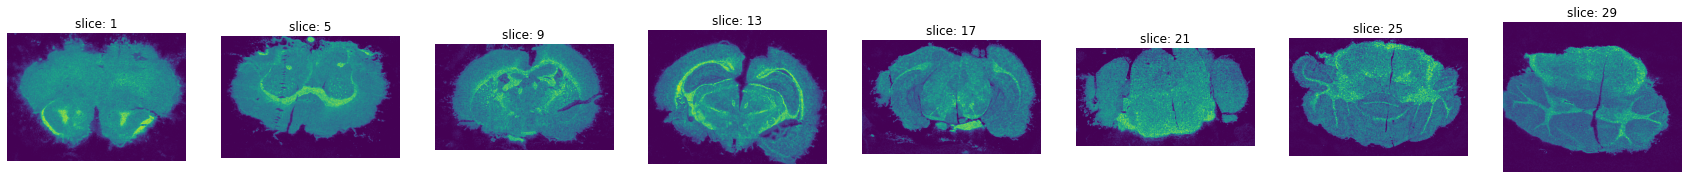

In [33]:
fig, ll_ax = plt.subplots(1, len(l_index_slices), figsize = (30,3*4))

for i, index in enumerate(l_index_slices):
        image =  np.sum([image[0] for index_lipid, image in enumerate(dic_l_images[index]) if len(image[0].shape)>0 ], axis = 0)
        #image_norm = image
        image_norm = image/np.max(image)*255
        ll_ax[i].imshow(image_norm)
        ll_ax[i].axis('off')
        ll_ax[i].set_title('slice: ' + str(index))
plt.show()

In [34]:
for name in l_names:
    index_slice = int(name.split('_')[1])
    image_tiff = []
    for j, l_index_to_keep in enumerate(ll_index_to_keep):
        image = np.sum([image[0] for index_lipid, image in enumerate(dic_l_images[index_slice]) if index_lipid in l_index_to_keep and len(image[0].shape)>0 ], axis = 0)
        #image = np.sum([image[0] for index_lipid, image in enumerate(dic_l_images[index_slice]) if len(image[0].shape)>0 ], axis = 0)
        image_norm = image/np.max(image)*255
        image_tiff.append(image_norm)
    
    to_tiff(image_tiff , 'images_tiff/slice_' + str(index_slice) + '.tiff', image_name='slice_' + str(index_slice), pixel_size=25)